In [96]:
# !pip install category_encoders
# !pip install fastapi uvicorn

In [97]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import fastapi, uvicorn, pydantic
from category_encoders import TargetEncoder
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [98]:
df=pd.read_csv("bmw.csv")

In [99]:
print(df.head())

       model  year  price transmission  mileage fuelType  tax   mpg  \
0   5 Series  2014  11200    Automatic    67068   Diesel  125  57.6   
1   6 Series  2018  27000    Automatic    14827   Petrol  145  42.8   
2   5 Series  2016  16000    Automatic    62794   Diesel  160  51.4   
3   1 Series  2017  12750    Automatic    26676   Diesel  145  72.4   
4   7 Series  2014  14500    Automatic    39554   Diesel  160  50.4   

   engineSize  
0         2.0  
1         2.0  
2         3.0  
3         1.5  
4         3.0  


In [100]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10781 entries, 0 to 10780
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         10781 non-null  object 
 1   year          10781 non-null  int64  
 2   price         10781 non-null  int64  
 3   transmission  10781 non-null  object 
 4   mileage       10781 non-null  int64  
 5   fuelType      10781 non-null  object 
 6   tax           10781 non-null  int64  
 7   mpg           10781 non-null  float64
 8   engineSize    10781 non-null  float64
dtypes: float64(2), int64(4), object(3)
memory usage: 758.2+ KB
None


In [101]:
print(df.nunique())

model             24
year              25
price           3777
transmission       3
mileage         8086
fuelType           5
tax               38
mpg              102
engineSize        17
dtype: int64


In [102]:
print(df.isnull().sum())

model           0
year            0
price           0
transmission    0
mileage         0
fuelType        0
tax             0
mpg             0
engineSize      0
dtype: int64


In [103]:
print(df.describe())

               year          price        mileage           tax           mpg  \
count  10781.000000   10781.000000   10781.000000  10781.000000  10781.000000   
mean    2017.078935   22733.408867   25496.986550    131.702068     56.399035   
std        2.349038   11415.528189   25143.192559     61.510755     31.336958   
min     1996.000000    1200.000000       1.000000      0.000000      5.500000   
25%     2016.000000   14950.000000    5529.000000    135.000000     45.600000   
50%     2017.000000   20462.000000   18347.000000    145.000000     53.300000   
75%     2019.000000   27940.000000   38206.000000    145.000000     62.800000   
max     2020.000000  123456.000000  214000.000000    580.000000    470.800000   

         engineSize  
count  10781.000000  
mean       2.167767  
std        0.552054  
min        0.000000  
25%        2.000000  
50%        2.000000  
75%        2.000000  
max        6.600000  


In [104]:
#EDA

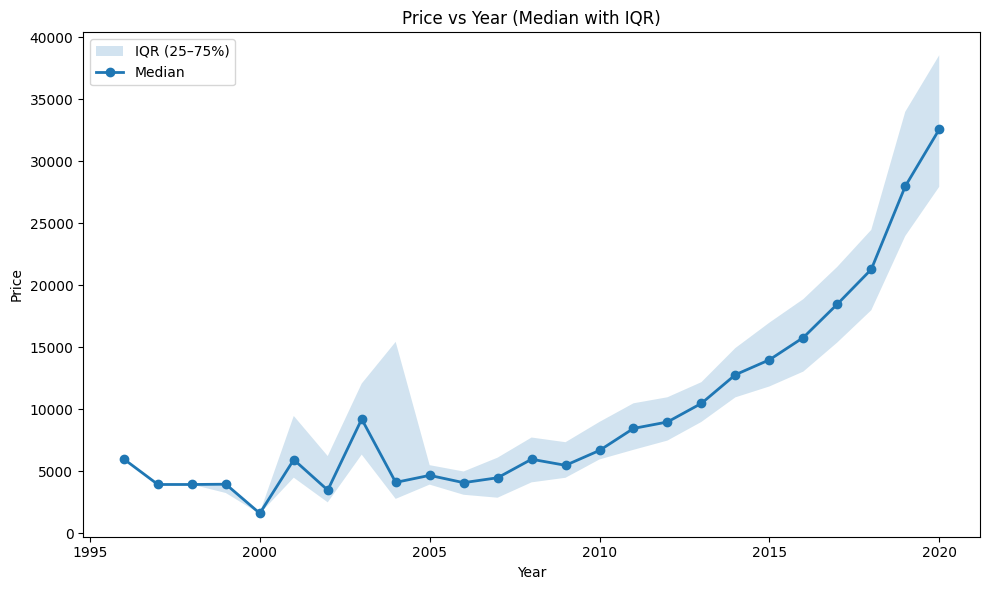

In [105]:
# Price vs Year: median line + IQR ribbon
year_stats = (
    df.groupby('year')['price']
      .agg(median='median',
           q25=lambda s: s.quantile(0.25),
           q75=lambda s: s.quantile(0.75))
      .reset_index()
)

plt.figure(figsize=(10,6))
# IQR ribbon
plt.fill_between(year_stats['year'], year_stats['q25'], year_stats['q75'], alpha=0.2, label='IQR (25–75%)')
# Median line
plt.plot(year_stats['year'], year_stats['median'], marker='o', linewidth=2, label='Median')
plt.title('Price vs Year (Median with IQR)')
plt.xlabel('Year'); plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()

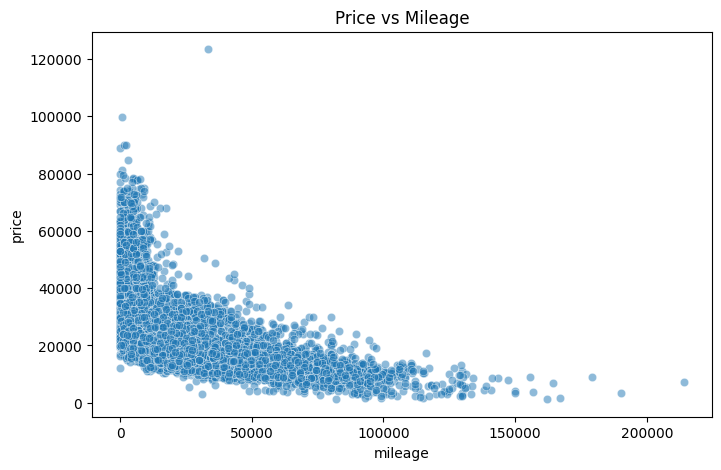

In [106]:
# Price vs Mileage
plt.figure(figsize=(8,5))
sns.scatterplot(x='mileage', y='price', data=df, alpha=0.5)
plt.title("Price vs Mileage")
plt.show()


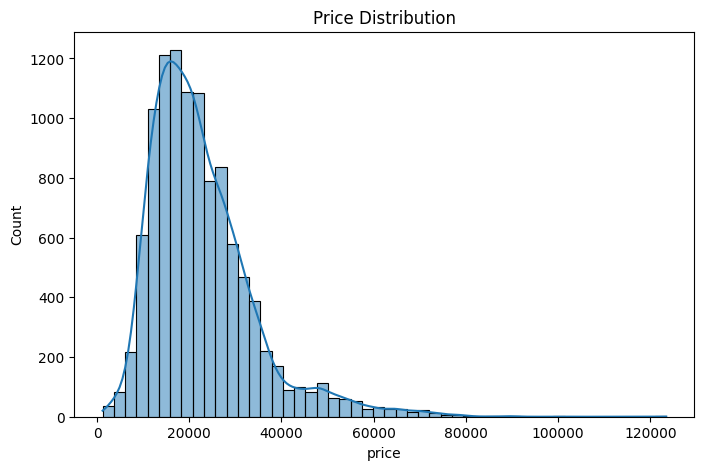

In [107]:
#price distirbuteion
# Distribution of price
plt.figure(figsize=(8,5))
sns.histplot(df['price'], bins=50, kde=True)
plt.title("Price Distribution")
plt.show()

In [108]:
# ---------------------------
# Cleaning
# ---------------------------
# cap unrealistic values & remove inconsistent categories
df = df[df['price'] < 80000]
df = df[df['mileage'] < 150000]
df = df[df['engineSize'] > 0.9]                 # remove 0 and 0.6; keep 1.0+
df = df[~df['fuelType'].isin(['Electric', 'Other'])]
df['model'] = df['model'].str.strip()
df = df[(df['mpg'] >= 5) & (df['mpg'] <= 100)]

print("✅ Cleaned dataset shape:", df.shape)
print("✅ Fuel types remaining:", df['fuelType'].unique())
print("✅ Engine size range:", df['engineSize'].min(), "to", df['engineSize'].max())

✅ Cleaned dataset shape: (10490, 9)
✅ Fuel types remaining: ['Diesel' 'Petrol' 'Hybrid']
✅ Engine size range: 1.5 to 6.6


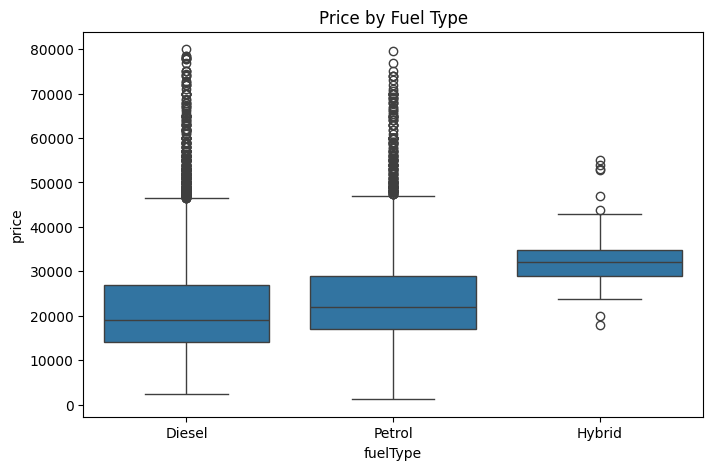

In [109]:

# Categorical: Fuel Type
plt.figure(figsize=(8,5))
sns.boxplot(x='fuelType', y='price', data=df)
plt.title("Price by Fuel Type")
plt.show()




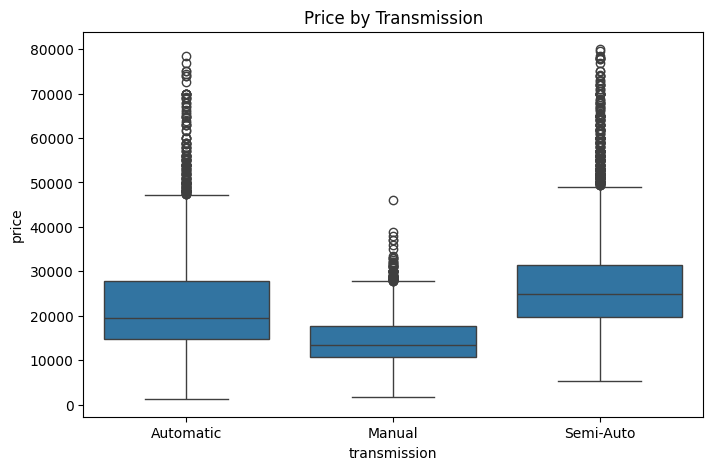

In [110]:
# Categorical: Transmission
plt.figure(figsize=(8,5))
sns.boxplot(x='transmission', y='price', data=df)
plt.title("Price by Transmission")
plt.show()

Text(0, 0.5, 'Count')

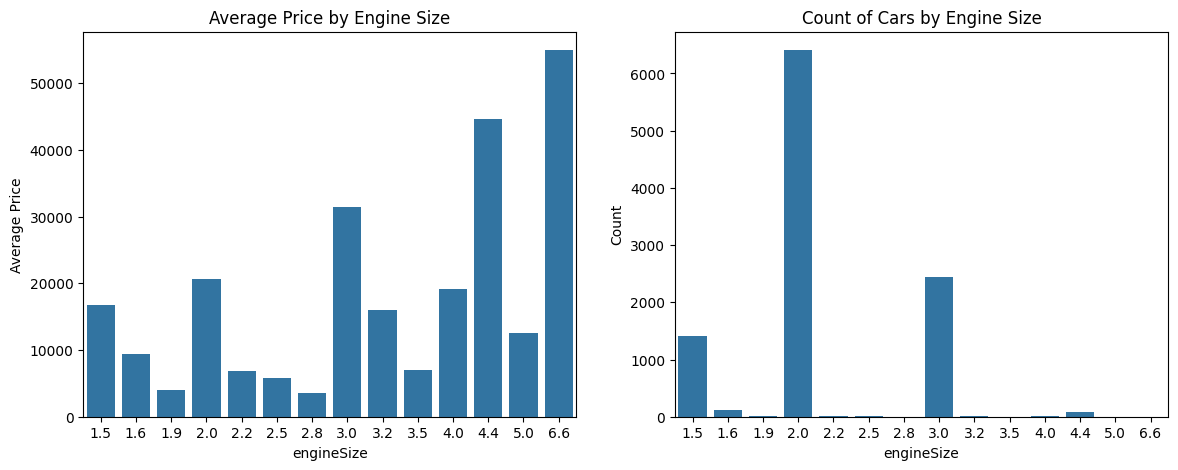

In [111]:
# Count of cars by engine size
fig, ax = plt.subplots(1,2, figsize=(14,5))

# Average price by engine size
sns.barplot(x="engineSize", y="price", data=df, ax=ax[0], errorbar=None)
ax[0].set_title("Average Price by Engine Size")
ax[0].set_ylabel("Average Price")

# Count of cars by engine size
sns.barplot(x="engineSize", y="price", data=df, ax=ax[1], estimator=len, errorbar=None)
ax[1].set_title("Count of Cars by Engine Size")
ax[1].set_ylabel("Count")

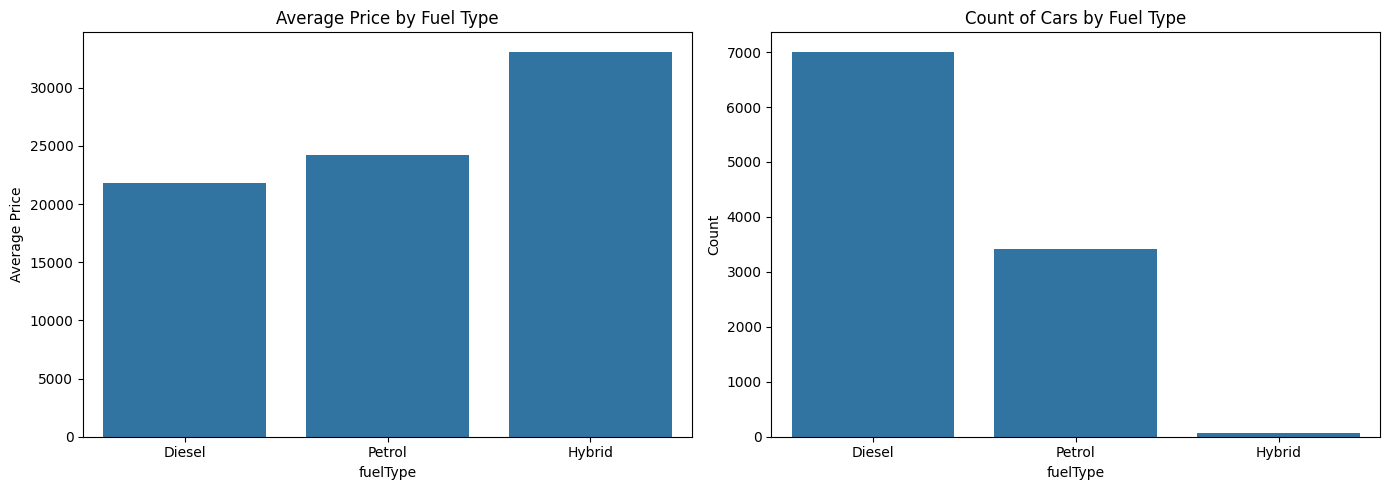

In [112]:
#Fuel Type Analysis
fig, ax = plt.subplots(1, 2, figsize=(14,5))

# Average price by fuel type
sns.barplot(x="fuelType", y="price", data=df, ax=ax[0], errorbar=None)
ax[0].set_title("Average Price by Fuel Type")
ax[0].set_ylabel("Average Price")

# Count of cars by fuel type
sns.barplot(x="fuelType", y="price", data=df, ax=ax[1], estimator=len, errorbar=None)
ax[1].set_title("Count of Cars by Fuel Type")
ax[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

In [113]:
 #---------------------------
# ▶ FEATURE ENGINEERING
# ---------------------------
# Age (ensure no zero/negative; dataset max year is 2020, so 2025-year >= 5)
df['age'] = 2025 - df['year']

# Guard against any accidental divide-by-zero (shouldn’t happen, but safe)
df['age'] = df['age'].replace(0, 1)

# Your engineered features
df['eng_age'] = df['engineSize'] / df['age']
df['mpg_eng'] = df['mpg'] / df['engineSize']
df['mpg_age'] = df['mpg'] / df['age']

# Extra useful signals
df['mileage_per_year'] = df['mileage'] / df['age']
df['tax_per_engine'] = df['tax'] / df['engineSize']

# Replace inf/-inf from any divisions and drop if still problematic
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(subset=['eng_age','mpg_eng','mpg_age','mileage_per_year','tax_per_engine'], inplace=True)#

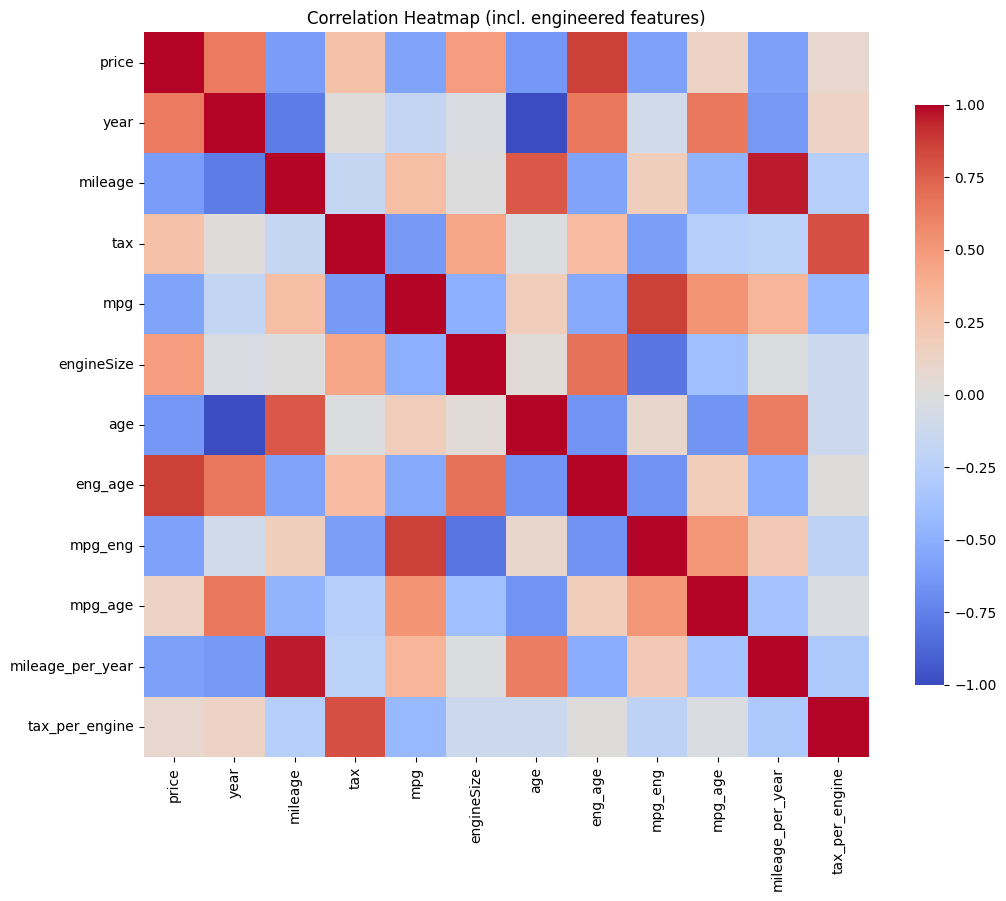

In [114]:
# ---------------------------
# Correlation Heatmap (on numeric features incl. engineered + target)
# ---------------------------
numeric_for_corr = [
    'price', 'year', 'mileage', 'tax', 'mpg', 'engineSize',
    'age', 'eng_age', 'mpg_eng', 'mpg_age', 'mileage_per_year', 'tax_per_engine'
]

corr = df[numeric_for_corr].corr()

plt.figure(figsize=(11,9))
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0, vmin=-1, vmax=1, square=True,
            cbar_kws={"shrink": .8})
plt.title("Correlation Heatmap (incl. engineered features)")
plt.tight_layout()
plt.show()

In [115]:
# Count how many cars per model
model_counts = df['model'].value_counts().sort_values(ascending=False)

print(model_counts)

model
3 Series    2332
1 Series    1963
2 Series    1187
5 Series    1002
4 Series     995
X1           804
X3           551
X5           458
X2           288
X4           179
M4           123
6 Series     108
Z4           108
X6           106
7 Series     104
X7            55
8 Series      37
M5            27
M3            27
M2            21
M6             8
Z3             7
Name: count, dtype: int64


In [116]:


# ---------------------------
# 0) Start from your cleaned + engineered df
# (assumes df already has: age, eng_age, mpg_eng, mpg_age, mileage_per_year, tax_per_engine)
# ---------------------------

# 1) Handle rare models BEFORE splitting (so both train/test agree on categories)
df_mod = df.copy()
model_counts = df_mod['model'].value_counts()
rare_models = model_counts[model_counts < 20].index  # threshold can be 20–50
df_mod['model'] = df_mod['model'].replace(rare_models, 'Rare')
print(f"Grouped {len(rare_models)} low-frequency models into 'Rare'")

# 2) Split features/target
y = df_mod['price'].copy()
X = df_mod.drop(columns=['price']).copy()

categorical_high = ['model']                       # Target Encoding
categorical_low  = ['transmission', 'fuelType']    # One-Hot Encoding
numerical = [
    'year','mileage','tax','mpg','engineSize',
    'age','eng_age','mpg_eng','mpg_age','mileage_per_year','tax_per_engine'
]

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)


Grouped 2 low-frequency models into 'Rare'


In [117]:

# 3) Fit encoders/scaler on TRAIN ONLY (no leakage)
# TargetEncoder with smoothing to tame rare/unstable categories
te = TargetEncoder(cols=categorical_high, smoothing=10)
X_train_te = te.fit_transform(X_train_raw[categorical_high], y_train)
X_test_te  = te.transform(X_test_raw[categorical_high])

print(X_train_te.head())

             model
2864  20203.417155
9299  20203.417155
5788  19736.247678
9561  15759.641462
9545  19464.483387


In [118]:

# One-Hot for low-cardinality
ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
X_train_ohe = ohe.fit_transform(X_train_raw[categorical_low])
X_test_ohe  = ohe.transform(X_test_raw[categorical_low])

print(X_train_ohe)

[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]]


In [119]:
# Scale numerics
scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train_raw[numerical])
X_test_num  = scaler.transform(X_test_raw[numerical])

print(X_train_num)

[[-1.72512172  0.44844716 -1.87640062 ... -0.66952928  0.11961044
  -1.95954223]
 [-2.14740744  2.23610462 -1.71048289 ... -1.12668834  1.49734327
  -1.77021217]
 [-0.03597882 -0.26226175 -0.13426445 ...  0.21921239 -0.17893553
   0.02842347]
 ...
 [ 0.80859262 -1.01699333  0.197571   ...  0.52243013 -1.19328634
   0.4070836 ]
 [ 0.80859262 -0.88540735  0.197571   ... -0.22202171 -0.95744438
  -0.50801172]
 [-0.03597882 -0.01001512 -0.13426445 ...  0.14393074  0.16014128
   0.02842347]]


In [120]:
# 4) Build final matrices (keep the SAME column order for train/test)
X_train = np.hstack([X_train_num, X_train_te, X_train_ohe])
X_test  = np.hstack([X_test_num,  X_test_te,  X_test_ohe])

print("Train/Test shapes:", X_train.shape, X_test.shape)

print(X_train)

Train/Test shapes: (8392, 16) (2098, 16)
[[-1.72512172  0.44844716 -1.87640062 ...  0.          0.
   0.        ]
 [-2.14740744  2.23610462 -1.71048289 ...  0.          0.
   0.        ]
 [-0.03597882 -0.26226175 -0.13426445 ...  1.          0.
   0.        ]
 ...
 [ 0.80859262 -1.01699333  0.197571   ...  0.          0.
   1.        ]
 [ 0.80859262 -0.88540735  0.197571   ...  0.          0.
   1.        ]
 [-0.03597882 -0.01001512 -0.13426445 ...  0.          0.
   0.        ]]


In [121]:
# 5) Train XGBoost
xgb_model = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.1,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(X_train, y_train)

# 6) Evaluate
y_pred = xgb_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("📊 XGBoost (smoothed TE(model='Rare') + OHE + scaling)")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.4f}")

📊 XGBoost (smoothed TE(model='Rare') + OHE + scaling)
MAE:  1428.76
RMSE: 2088.45
R²:   0.9651


In [122]:
# =========================
# Predict for ALL rows (cleaned+engineered df) using the TRAIN-FITTED pipeline
# =========================

# Use the same df_mod you trained with (where rare models were mapped to 'Rare')
X_all_raw = df_mod.drop(columns=['price']).copy()

# Transform with train-fitted encoders/scaler (do NOT refit!)
X_all_num = scaler.transform(X_all_raw[numerical])
X_all_te  = te.transform(X_all_raw[categorical_high])     # uses train-fitted TargetEncoder
X_all_ohe = ohe.transform(X_all_raw[categorical_low])     # uses train-fitted OneHotEncoder

# Build the matrix in the SAME order as training
X_all_preprocessed = np.hstack([X_all_num, X_all_te, X_all_ohe])

# Predict every row
all_predictions = xgb_model.predict(X_all_preprocessed)

# Attach predictions
df_with_preds = df_mod.copy()
df_with_preds["predicted_price"] = all_predictions
df_with_preds["residual"] = df_with_preds["price"] - df_with_preds["predicted_price"]

# Peek a few rows
print(df_with_preds[["model", "year", "mileage", "engineSize", "price", "predicted_price", "residual"]].head(10))


      model  year  mileage  engineSize  price  predicted_price     residual
0  5 Series  2014    67068         2.0  11200     12680.157227 -1480.157227
1  6 Series  2018    14827         2.0  27000     26832.587891   167.412109
2  5 Series  2016    62794         3.0  16000     15914.260742    85.739258
3  1 Series  2017    26676         1.5  12750     13180.598633  -430.598633
4  7 Series  2014    39554         3.0  14500     14907.706055  -407.706055
5  5 Series  2016    35309         2.0  14900     15746.030273  -846.030273
6  5 Series  2017    38538         2.0  16000     16534.484375  -534.484375
7  2 Series  2018    10401         1.5  16250     16429.480469  -179.480469
8  4 Series  2017    42668         2.0  14250     14992.546875  -742.546875
9  5 Series  2016    36099         2.0  14250     14326.267578   -76.267578


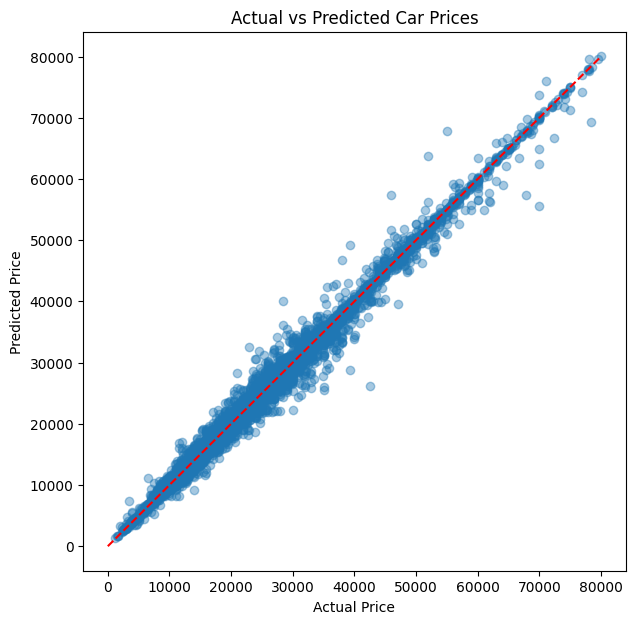

In [123]:
#DOUBLE CHECK


plt.figure(figsize=(7,7))
plt.scatter(df_with_preds["price"], df_with_preds["predicted_price"], alpha=0.4)
plt.plot([0,80000],[0,80000], color='red', linestyle='--')  # perfect prediction line
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Car Prices")
plt.show()

The scatter plot shows that predicted prices align very closely with actual prices, clustering around the perfect diagonal. This, along with an R² of 0.965, demonstrates that the model generalizes well, with only minor deviations for very high-end cars.


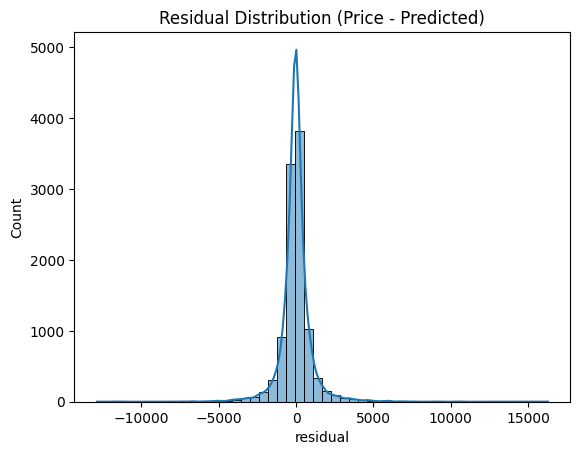

In [124]:


sns.histplot(df_with_preds["residual"], bins=50, kde=True)
plt.title("Residual Distribution (Price - Predicted)")
plt.show()

“The residuals are tightly centered around zero and symmetrically distributed, confirming that the XGBoost model makes unbiased predictions with small, random errors, and only a few large deviations for rare luxury models.”



In [125]:
print(df_with_preds.groupby("model")[["price","predicted_price"]].mean().head(22))

                 price  predicted_price
model                                  
1 Series  15836.408049     15823.916992
2 Series  19437.822241     19522.373047
3 Series  20036.102058     20024.964844
4 Series  22498.418090     22459.234375
5 Series  22177.209581     22169.095703
6 Series  24354.370370     24409.820312
7 Series  36846.519231     36873.738281
8 Series  62757.729730     62074.363281
M2        43140.333333     42820.367188
M3        30229.777778     29789.800781
M4        42433.650407     42578.523438
M5        55703.703704     55421.792969
Rare      19887.000000     19324.445312
X1        19816.564677     19796.494141
X2        28486.663194     28527.619141
X3        27758.310345     27814.195312
X4        32721.335196     32750.312500
X5        39484.897380     39549.191406
X6        43838.613208     43742.687500
X7        69842.763636     69560.656250
Z4        27001.935185     27037.226562


The model’s predicted average prices align very closely with actual averages for each BMW model, confirming strong performance across both common and luxury segments, with only minor deviations in rare categories.

In [126]:
import joblib

# Save model
joblib.dump(xgb_model, "xgb_model.pkl")

# Save preprocessing objects
joblib.dump(te, "target_encoder.pkl")
joblib.dump(ohe, "onehot_encoder.pkl")
joblib.dump(scaler, "scaler.pkl")

print("✅ Model and preprocessing objects saved as .pkl files")

✅ Model and preprocessing objects saved as .pkl files


In [127]:
import category_encoders,matplotlib

print("pandas:", pd.__version__)
print("numpy:", np.__version__)
print("scikit-learn:", sklearn.__version__)
print("xgboost:", xgb.__version__)
print("category_encoders:", category_encoders.__version__)
print("matplotlib:", matplotlib.__version__)
print("seaborn:", sns.__version__)
print("joblib",joblib.__version__)

pandas: 2.2.2
numpy: 2.0.2
scikit-learn: 1.6.1
xgboost: 3.0.5
category_encoders: 2.8.1
matplotlib: 3.10.0
seaborn: 0.13.2
joblib 1.5.2


In [128]:
import fastapi, uvicorn, pydantic
print("fastapi:", fastapi.__version__)
print("uvicorn:", uvicorn.__version__)
print("pydantic:", pydantic.__version__)

fastapi: 0.116.2
uvicorn: 0.35.0
pydantic: 2.11.9


In [129]:
import sys
print(sys.version)

3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
